# Lab CMBLenses

In [19]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [2]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [65]:
Nside = 64
T = Float64;

In [132]:
prob = load_cmb_lensing_problem(;storage=CuArray, T, Nside, masking=true);

# MCHMC

## Init

In [360]:
target = CMBLensingTarget(prob);

In [361]:
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);

## Sample

In [404]:
spl = MCHMC(500, 0.0001; adaptive=true, init_eps=10, init_L=10.0*sqrt(50), sigma=one(LenseBasis(diag(target.Λmass))));

In [405]:
prob.ncalls[] = 0
samples_mchmc = adapt(Array, Sample(spl, target, 10000, dialog=false, progress=true));
ncalls_mchmc = prob.ncalls[]

MCHMC: 100%|████████████████████████████████████████████| Time: 0:07:11
  ϵ:     10.588584979284546
  dE/d:  9.346081914053965e-6


44000

In [406]:
chain_mchmc = Chains(
    permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf],
);

In [407]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
  39.475034999273255
 203.01854913122386

In [408]:
ess_per_call_mchmc = ess_mchmc / ncalls_mchmc

2-element Vector{Float64}:
 0.0008971598863471194
 0.004614057934800542

## Plot

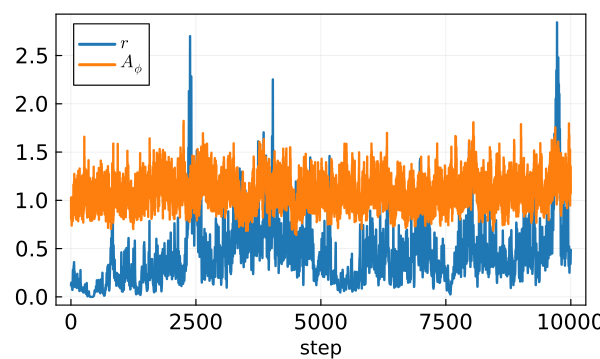

In [409]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

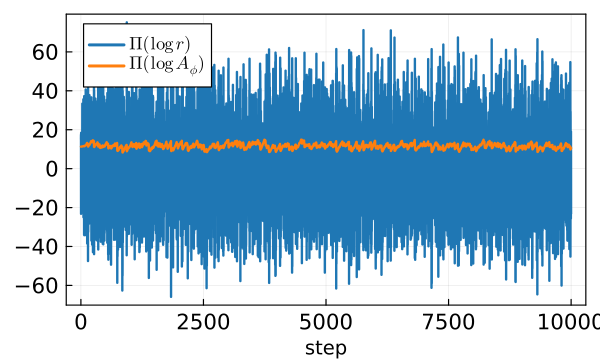

In [410]:
plot(chain_mchmc[:p_logr], label=L"\Pi(\log \, r)", xlabel="step")
plot!(chain_mchmc[:p_logAϕ], label=L"\Pi(\log \, A_\phi)")

In [411]:
std(chain_mchmc[:dE])^2/d

0.00010453603234043727

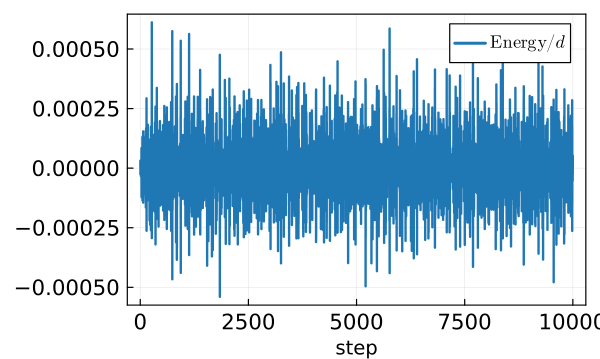

In [412]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

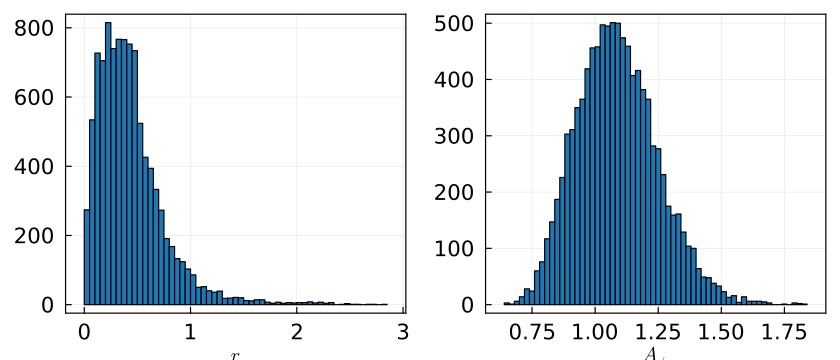

In [413]:
plot(
    histogram(chain_mchmc[:r], xlabel=L"r", label=nothing, lw=1),
    histogram(chain_mchmc[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
    size = (700,300)
)

### Animation

In [ ]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples_mchmc[end][1:end-2]);

In [ ]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

In [ ]:
ϕs = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples_mchmc[end-500:end]]
anim = @animate for i in 1:length(ϕs)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(ϕs, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

In [ ]:
mp4(anim, "kappa_samples.mp4", fps = 25)

# HMC

In [394]:
Ω = prob.Ωstart
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
@showprogress for i=1:500
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=0.05)], progress=false, always_accept=(i<10))
    push!(samples_hmc, state)
end
ncalls_hmc = prob.ncalls[]

Progress: 100%|█████████████████████████████████████████| Time: 0:07:14


28000

In [395]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

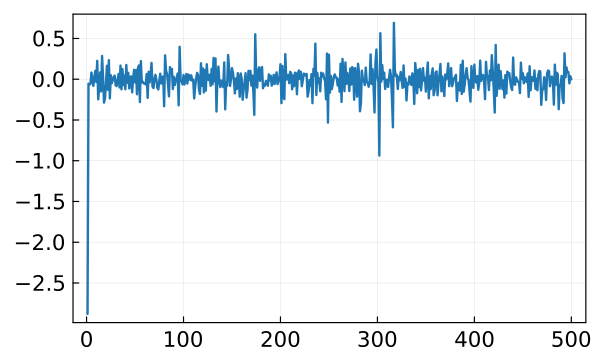

In [396]:
plot(getindex.(samples_hmc, 2))

## Plot

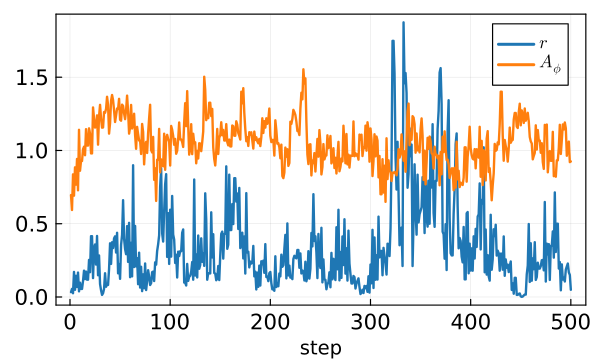

In [397]:
plot(chain_hmc[:r], label=L"r", xlabel="step")
plot!(chain_hmc[:Aϕ], label=L"A_\phi")

In [398]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 24.727418314520136
 12.448345484937201

In [399]:
ess_per_call_hmc = ess_hmc ./ ncalls_hmc

2-element Vector{Float64}:
 0.0008831220826614334
 0.00044458376731918575

# MUSE

In [90]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [91]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [92]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseProblem, θ) = exp.(θ)

In [72]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [93]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

MUSE: 100%|█████████████████████████████████████████████| Time: 0:04:39
get_H: 100%|████████████████████████████████████████████| Time: 0:00:17


In [421]:
chain_muse = Chains(permutedims(rand(result.dist,1000000)), [:logr, :logAϕ]);

In [422]:
ess_per_call_muse = nsims / ncalls_muse

0.006596741209842338

## Plot

In [ ]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(first.(x), yscale=:log10)
        end
        plot!(first.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    # ylim = (1e-7, 1e-3)
)

In [ ]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(last.(x), yscale=:log10)
        end
        plot!(last.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    ylim = (1e-7, 1e-3)
)

In [ ]:
plot(
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :r), m="."),
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :Aϕ), m=".")
)

# Compare

In [419]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

14.838016353184246

In [420]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

7.352915918590232

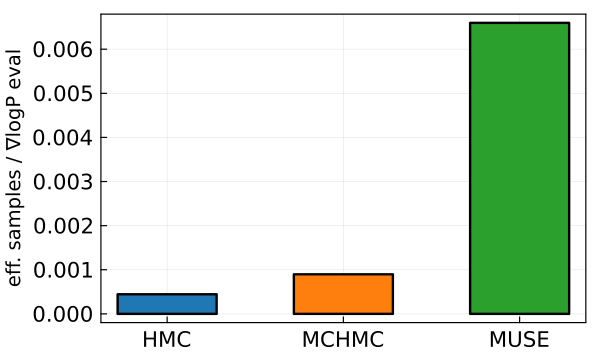

In [414]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval"
)

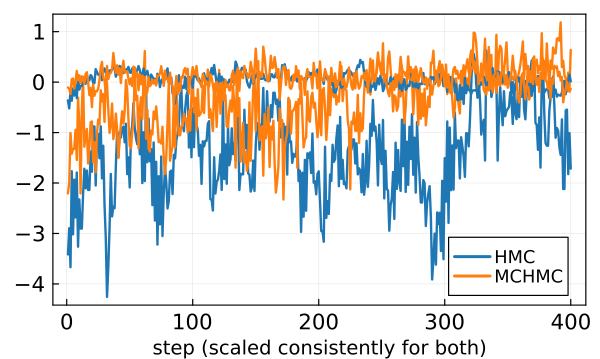

In [401]:
p = plot(label=L"r", xlabel="step (scaled consistently for both)")
for k in [:r, :Aϕ]
    plot!(log.(chain_hmc[k][1:length(chain_mchmc)÷25]), c=1, label=(k==:r ? "HMC" : nothing))
    plot!(log.(chain_mchmc[k][1:25:end]), c=2, label=(k==:r ? "MCHMC" : nothing))
end
p

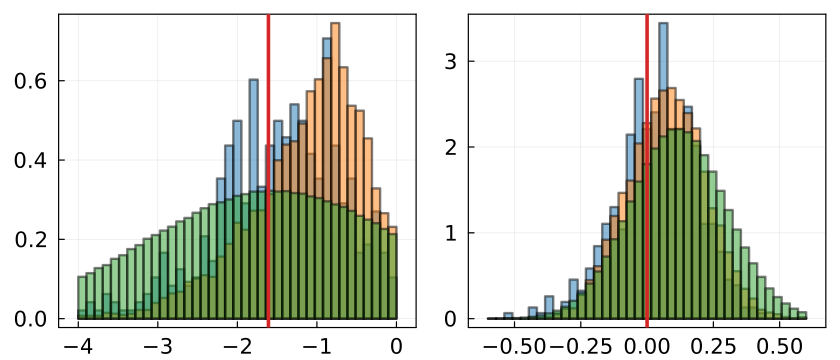

In [423]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40))
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40))
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40))
        vline!([prob.Ωtrue.θ.r], c=4, lw=3)
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40))
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40))
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40))
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3)
    end, 
    size = (700, 300)
)